Credit card frauds are detected using classification algorithms. The algorithms use basic transaction information and decide whether the transaction is legit or fraud. 

Use this data and develop an algorithm to detect fraudulent transactions. Some instructions are available from the 31.1.2023 lecture. 

You may use MLPClassifie, HistGradientBoostingClassifier, GradientBoostingClassifier or XGboost. You can also compare different models. 

Pay attention to the following questions:
- Which features can be included in the model?
- What is the effect of model (hyper) parameters?
- How successful is the model? 
- What is the success rate for legit and fraud predictions?

In [29]:
#import ML libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import shap
import xgboost
import pandas as pd

In [30]:
df_raw = pd.read_csv("fraud_challenge_150k.csv")
df_raw.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,12/29/2020 9:05,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,6/22/2021 18:05,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,X,5/10/2021 13:48,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,N,3/11/2021 7:36,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,G,3/27/2021 6:13,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


In [31]:
#Data selection and processing
#Drop columns we cannot use, make your selection!
df = df_raw
df = df.drop(columns = ['email_domain','ip_address', 'user_agent','phone_number','billing_city','billing_address','billing_postal','EVENT_TIMESTAMP','applicant_name','merchant_id','locale'])

#One-hot-encoding
# Select only that amount of parameters your computer can one-hot-encode
hotlist = ('billing_state','currency','cvv','signature_image','transaction_type','transaction_env','tranaction_initiate')

for i in range(len(hotlist)):
    one_hot_encoded = pd.get_dummies(df[hotlist[i]], prefix = hotlist[i]).astype('int')
    df = pd.concat([df,one_hot_encoded], axis = 1) #Join data
    df = df.drop(columns = [hotlist[i]])


df.loc[df['EVENT_LABEL'].str.contains('legit', na = False),'EVENT_LABEL'] = 1
df.loc[df['EVENT_LABEL'].str.contains('fraud', na = False),'EVENT_LABEL'] = 0
df['EVENT_LABEL'] = df['EVENT_LABEL'].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 191 entries, account_age_days to tranaction_initiate_Z
dtypes: float64(7), int32(184)
memory usage: 113.3 MB


In [32]:
#Prepare data for model
Y = df['EVENT_LABEL'].values #Target
X = df.drop(columns = ['EVENT_LABEL']) #Features
names = X.columns #Save column names
X = X.values

#Divide data to test and train groups
X_train, X_test, y_train, y_test = train_test_split(X, Y,train_size = 0.7) #create numpy arrays

X_train = pd.DataFrame(data=X_train, columns=names)
X_test = pd.DataFrame(data=X_test, columns=names)

In [33]:
#Definition of model

#model = MLPClassifier()
#model = HistGradientBoostingClassifier()
#model =GradientBoostingClassifier(max_depth=3, random_state=0)
model = xgboost.XGBClassifier(n_estimators=2,tree_method='hist',subsample=0.67,colsample_level=0.06,verbose=0,n_jobs=6,random_state=12)

model.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

[20:07:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_level", "verbose" } are not used.

Accuracy on training set: 0.967
Accuracy on test set: 0.967


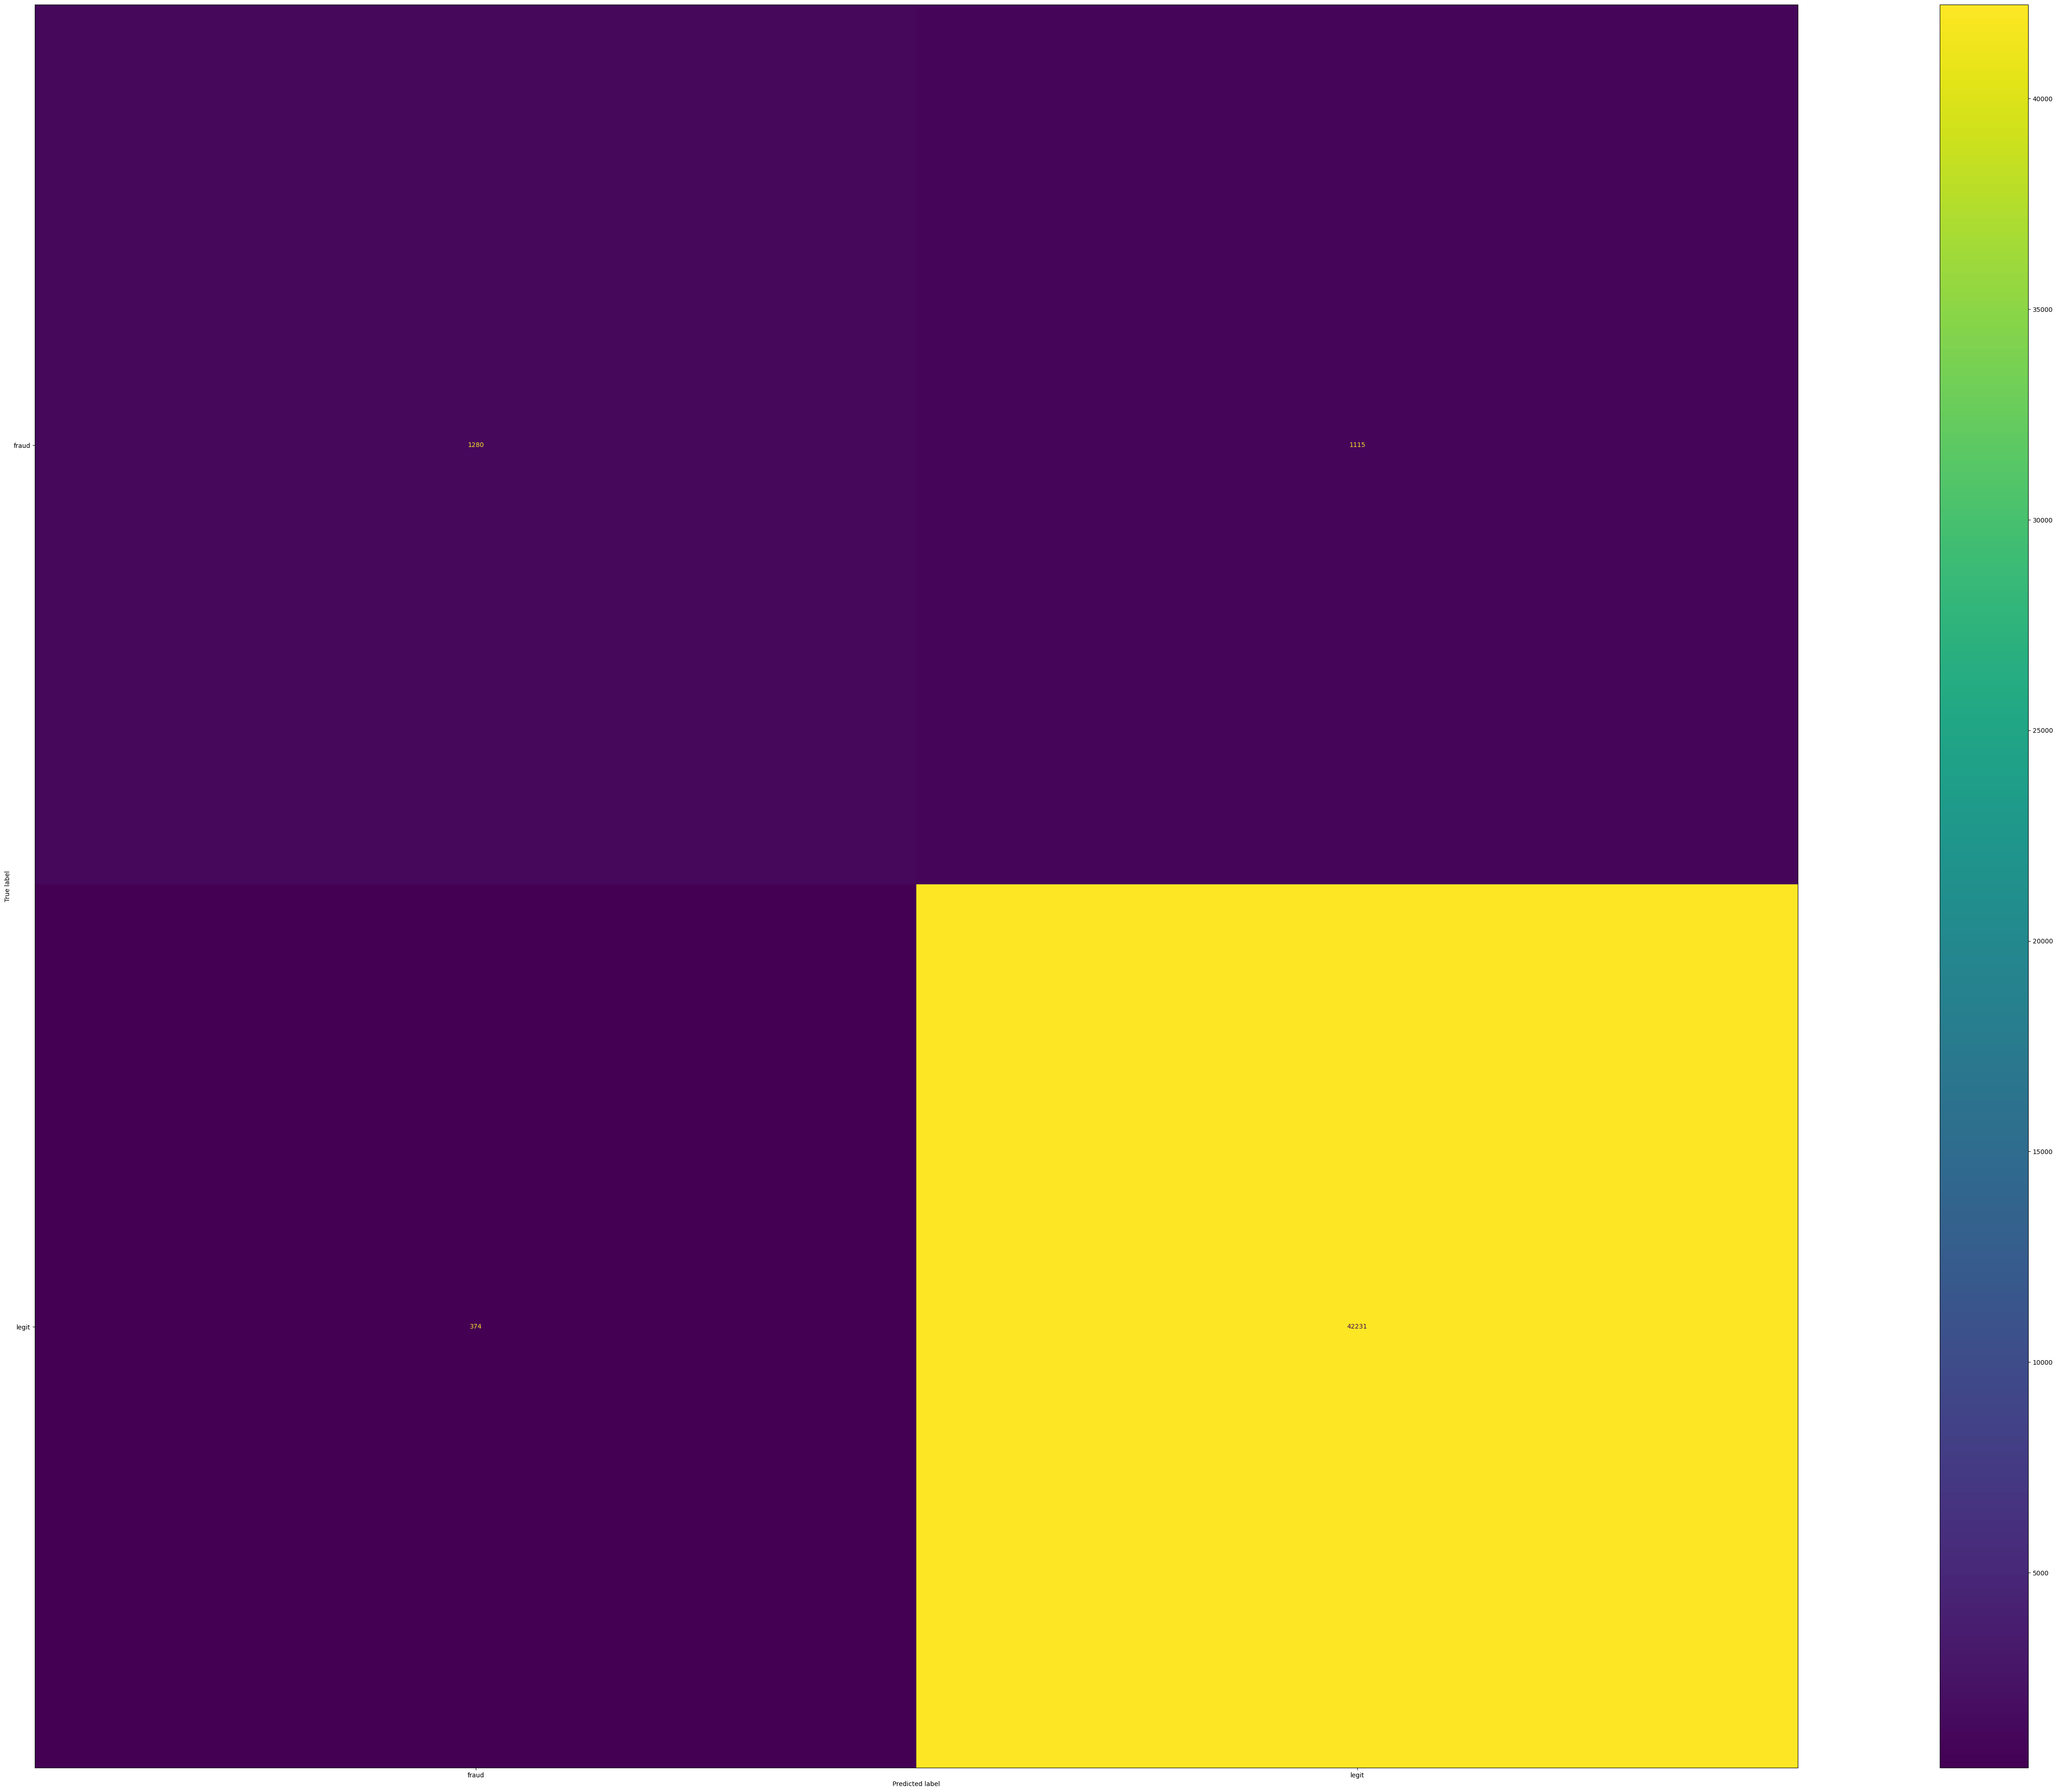

In [34]:
#Confusion Matrix
actual = y_test
predicted = model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['fraud', 'legit'])
cm_display.plot()
plt.show()

In [35]:
#calculate other metrics of the matrix
Precision = metrics.precision_score(actual, predicted)
F1_score = metrics.f1_score(actual, predicted)
Sensitivity = metrics.recall_score(actual, predicted)
print('Precision = ', Precision)
print('F1_score = ', F1_score)
print('Sensitivity =', Sensitivity)

Precision =  0.974276749873114
F1_score =  0.9826761759607219
Sensitivity = 0.9912216875953527


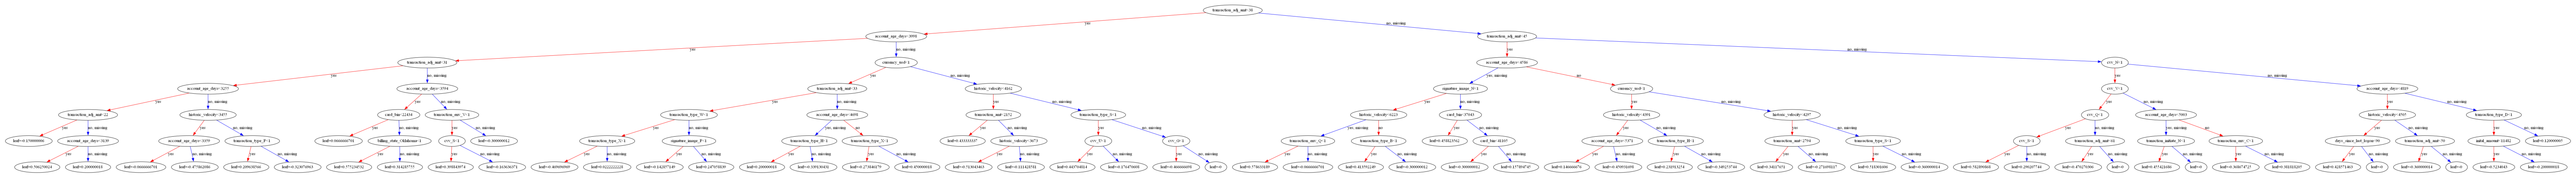

In [36]:
#Show the decision tree to see predicted events can be fraud or legit
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' #Graphviz needs to be installed
from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50
plot_tree(model,fontsize=22)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


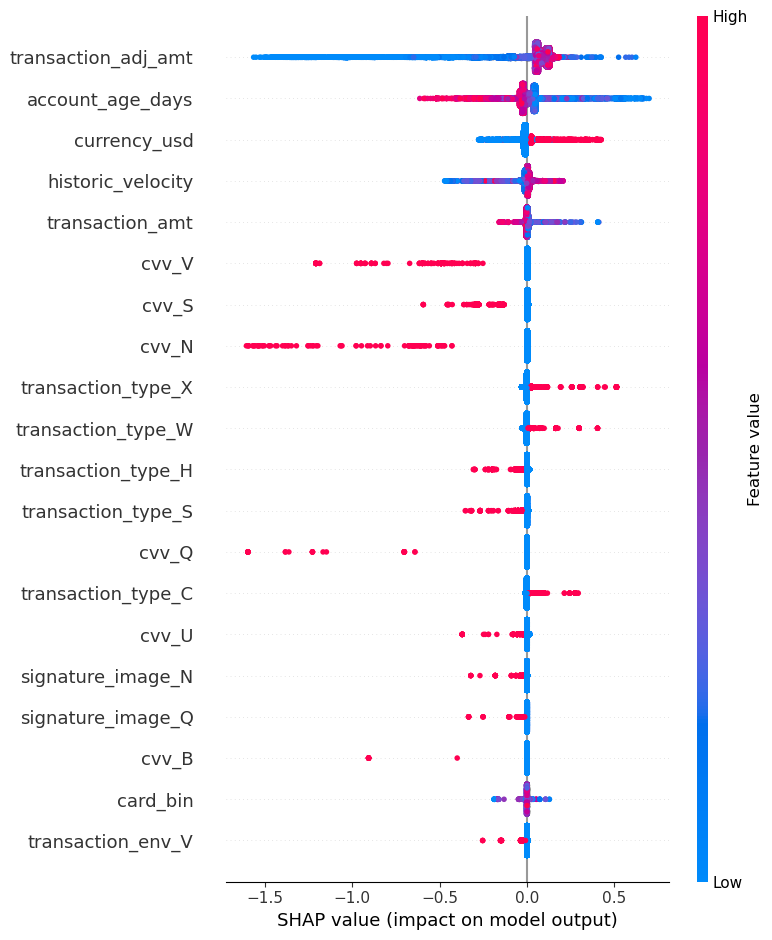

In [37]:
#Show SHAP values
explainer = shap.TreeExplainer(model)
pred = model.predict(X_test, output_margin=True)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

#Show the importance of parameters in terms of classification 
values = explainer(X_test)
shap.plots.bar(values)

1. Which features can be included in the model? 
- All features excluding those who cannot be converted to float values can be included in the model, for instance, 'email_domain','ip_address', 'user_agent','phone_number','billing_city','billing_address'cannot be used for the model.
- one hot encoding is used to convert categorical values into numerical values to use for modeling.

2. What is the effect of model (hyper) parameters?
There are different parameters in XGBoost that can be tried, e.g. gamma, eval_metric, base_score, etc. These values can be put into default mode to minimize the impact on model performance.

3. How successful is the model?
The model is quite successful with:
Accuracy on training set is 0.967
Accuracy on test set is 0.967
Precision on test set is 0.973 # show how many percentage of positives predicted are truly positive
Sensitivity (or Recall) of the test set = 0.993 # show how well the model predicts positive cases
F1-score on test set: 0.983 # show the mean of false positive and false negative cases and it is good to consider the metric in this case as this is quite an imbalanced dataset

4. What is the success rate for legit and fraud predictions?
The model seems to have a good fraud detection capability, which is shown through the sensitivity and F1-score. The sensitivity rate, or the rate of fraud detection of the model is 98.3%.